# GZ3D VAC usage within Marvin

This Notebook will demonstrate how to access and use GZ3D masks.  
For more information on GZ3D see the [VAC documentation website](https://www.sdss.org/dr17/data_access/value-added-catalogs/?vac_id=galaxyzoo-3d) or [Masters et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021MNRAS.507.3923M/abstract), which is the paper describing the project.
 
We will start by importing both [```marvin```](https://sdss-marvin.readthedocs.io/en/latest/) and some [```matplotlib```](https://matplotlib.org/) functions

In [1]:
import marvin
marvin.config.download = True
marvin.config.release = 'DR17'

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

print('Marvin and Matplotlib imported. Warnings about missing paths/files are typical, so no need to be concerned')

[INFO]: No release version set. Setting default to MPL-11
[WARNING]: redis-py works best with hiredis. Please consider installing (UserWarning)


Marvin and Matplotlib imported. Warnings about missing paths/files are typical, so no need to be concerned


The cell below just increases matplotlib font size, tick size, and line thickness to make for better plots.

In [2]:
style = {
    'lines.linewidth': 1.5,
    'font.size': 16.0,
    'axes.linewidth': 1.5,
    'axes.titlesize': 'large',
    'axes.labelsize': 'large',
    'xtick.major.size': 6,
    'xtick.minor.size': 4,
    'xtick.major.width': 1.5,
    'xtick.minor.width': 1.5,
    'xtick.major.pad': 6,
    'xtick.minor.pad': 6,
    'xtick.labelsize': 'medium',
    'ytick.major.size': 6,
    'ytick.minor.size': 4,
    'ytick.major.width': 1.5,
    'ytick.minor.width': 1.5,
    'ytick.major.pad': 6,
    'ytick.minor.pad': 6,
    'ytick.labelsize': 'medium',
    'legend.fancybox': True,
    'legend.fontsize': 'small',
    'legend.scatterpoints': 5,
    'legend.loc': 'best',
    'figure.titlesize': 'large',
}

plt.style.use(style)

## Accessing the Files in the VAC

The GZ3D data can be accessed either through the [`marvin.tools.Cube`](https://sdss-marvin.readthedocs.io/en/latest/tools/cube.html#marvin-cube) object or the [`marvin.tools.Maps`](https://sdss-marvin.readthedocs.io/en/latest/tools/maps.html) object using the `.vacs.gz3d` attribute.  This attribute will return a special `GZ3DTarget` class instance that will aid in processing and using the GZ3D VAC fits files.  Calling `print` on this instance will show summary information about the GZ3D classifications.

For the example we include below, ```manga_id = 1-604761``` this should return the below, which summarizes some data about the galaxy, how many GZ3D volunteers classified on each of the three tasks (center/star identification; drawing around the bar; drawing around the spirals), as well as how many clusters are returned for galaxy centers and foreground stars (if present). In this example all three tasks return masks. Some MaNGA galaxies do not have bars and/or spiral arms and will only have center/star counts. 

```
Subject info:
    subject id: 14742283
    manga id: 1-604761
    ra: 113.47227478027344
    dec: 37.02590560913086
    ifu size: 127
Classification counts:
    15 center/star, 15 non_blank
    15 spiral, 14 non_blank
    15 bar, 15 non_blank
Cluster counts:
    1 center(s)
    3 star(s)
```


In [3]:
manga_id = '1-604761'

cube = marvin.tools.Cube(manga_id)
data = cube.vacs.gz3d
print(data)

[WARNING]: mismatch between file version=MPL-11 and object release=DR17. Setting object release to MPL-11 (MarvinUserWarning)


Subject info:
    subject id: 14742283
    manga id: 1-604761
    ra: 113.47227478027344
    dec: 37.02590560913086
    ifu size: 127
Classification counts:
    15 center/star, 15 non_blank
    15 spiral, 14 non_blank
    15 bar, 15 non_blank
Cluster counts:
    1 center(s)
    3 star(s)


## Plotting the image and feature masks

Each GZ3D fits file includes the original (SDSS) image shown to the volunteers. A hexagon was overlayed to indicate roughly the region where spectra would be taken by the MaNGA IFU. Unfortunately the hexagon that was shown is slightly smaller than the true IFU size due to a bug in the code that made the cutout images (magenta), the correct IFU will be over layed (grey) by default when displaying the image. For those interested, the source of this bug was not accounting for the space between IFU fibers when making the image for GZ3D (it assumed each fiber was 2 arcsec on the sky when in reality they are 2.5 arcsec on the sky).

To plot the original image you can use the `plot_image` method and to plot the various masks you can use the `plot_masks` method.  Below are some examples using these methods that shows how to pass in existing `axis` objects for embedding these in subplots.  Note: `plot_masks` uses `matplotlib`'s [`GridSpec`](https://matplotlib.org/stable/tutorials/intermediate/gridspec.html) internally when colorbars for each of the masks, so the example below will use this method for creating subplots but normal `axis` objects can be passed in on `subplot_spec` and it will work.

If you pass in a your own `axis` object make sure the `projection` is set to the correct WCS for the image (see example below).

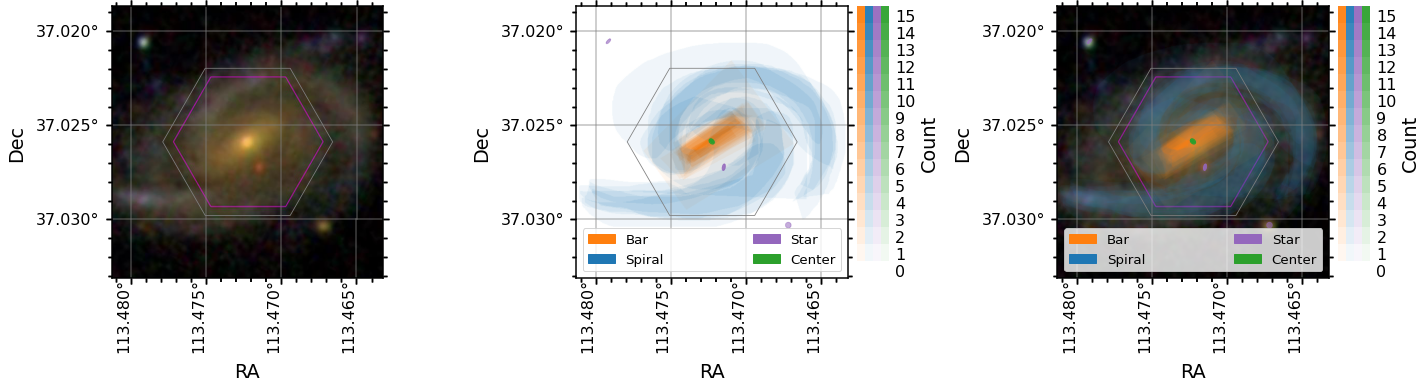

In [4]:
#Setting up the plot
plt.figure(figsize=(23, 5))
gs = gridspec.GridSpec(1, 3, wspace=0.5)
ax0 = plt.subplot(gs[0], projection=data.wcs)

#Plot the orignal image shown to GZ3D volunteers
data.plot_image(color_grid='grey', ax=ax0)

#Plot a heat map showing vote counts for the four different tasks in GZ3D. We call these feature masks. 
data.plot_masks(color_grid='grey', subplot_spec=gs[1]);

#As above, but overlay on the image
data.plot_masks(show_image=True, color_grid='grey', subplot_spec=gs[2]);

## Image vs Spaxel masks

The GZ3D feature masks are created in the pixel coordinates of the image shown to the volunteers (which have ~0.1 arcsecond pixels), but to be useful for MaNGA maps they are projected into spaxel space (a spaxel is a spatial pixel in a MaNGA data cube, which are gridded on 0.5arcsecond spaxels).  The image masks are found on the attributes `bar_mask`, `spiral_mask`, `star_mask`, and `center_mask` while the spaxel masks are found on `bar_mask_spaxel`, `spiral_mask_spaxel`, `star_mask_spaxel`, and `center_mask_spaxel`.  Below are some plots showing how this process is done.

The spaxel masks are all the same size and orientation as the `manga.tools.maps.Maps` arrays and can be used directly as masks for those arrays.

Note: The WCS for MaNGA maps (and the spaxel masks) has the y-axis flipped compared to the image (and original mask) WCS.  In the plot below the `ylim` of the axis is inverted to keep the orientation the same.  The Dec values are correct, the origin is just flipped.

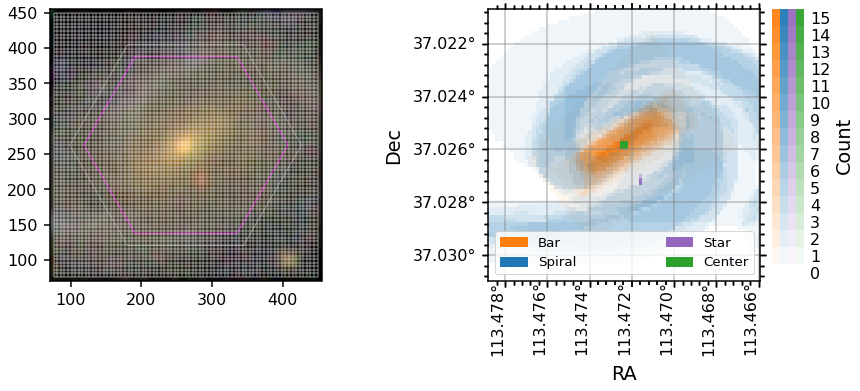

In [5]:
fig = plt.figure(figsize=(14, 5))
gs = gridspec.GridSpec(1, 2, wspace=0.4)

ax0 = plt.subplot(gs[0])
ax0.imshow(data.image)
# add the correct IFU hexagon to the image plot
ax0.add_patch(data.get_hexagon(edgecolor='C7'))

# plot the lines for the spaxel grid
v_grid, h_grid = data.get_spaxel_grid()
ax0.vlines(v_grid[0], ymin=v_grid[1][0], ymax=v_grid[1][1], color='white', alpha=0.2)
ax0.hlines(h_grid[1], xmin=h_grid[0][0], xmax=h_grid[0][1], color='white', alpha=0.2)

# zoom in on the image to show the grid clearly
ax0.set_xlim(70, 455)
ax0.set_ylim(70, 455)

# plot the spaxel masks
data.plot_masks(color_grid='grey', spaxel_masks=True, subplot_spec=gs[1])
ax1 = fig.axes[1]

# flip the y-axis to match the orientation of other plots
ax1.set_ylim(*ax1.get_ylim()[::-1]);

## Placing GZ3D mask contours on marvin maps

You may wish to overlay contours at some appropriate vote threshold onto a MaNGA map. 

To get an image in the same orientation as the maps you can use [`marvin.tools.Image`](https://sdss-marvin.readthedocs.io/en/latest/tools/image.html), plot it along side the spaxel masks, and then use the masks as contours on top of any `marvin` map plot. 

For these plots we demonstrate how to show one contour level, which in this example corresponds to the contour within which four or more volunteers marked a spaxel as belonging to each of the masks.

[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)


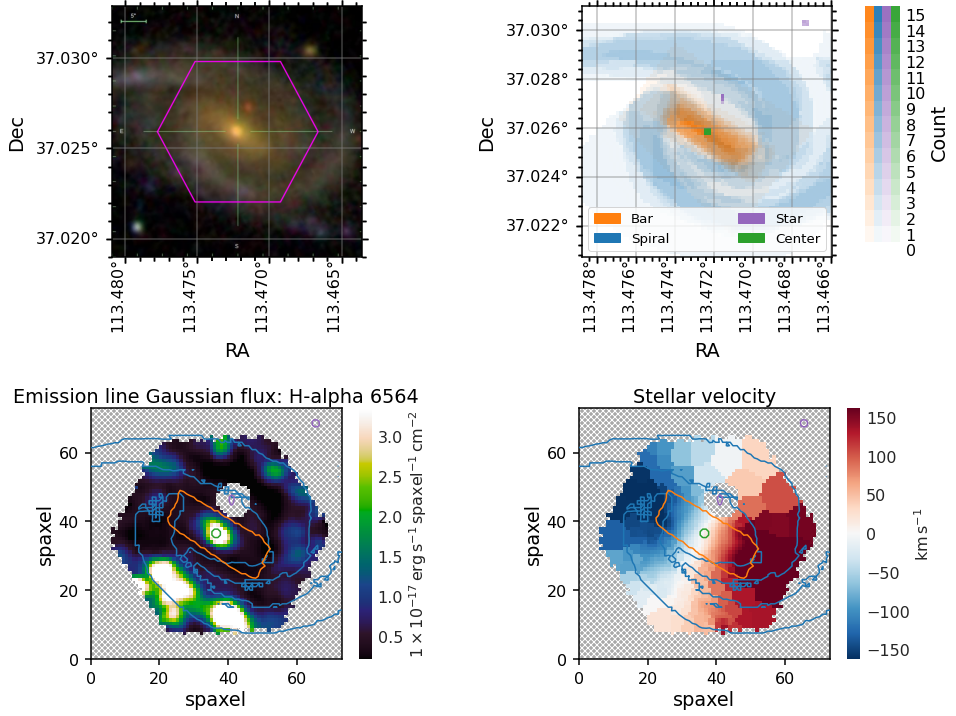

In [6]:
#Get the Image from Marvin
image = marvin.tools.Image(manga_id)

# Set up the Multiplot. 
fig = plt.figure(figsize=(15, 12))
gs = gridspec.GridSpec(2, 2, wspace=0.4, hspace=0.6)

# Plot the original image as stored in Marvin
ax0 = plt.subplot(gs[0, 0], projection=image.wcs)
data._set_up_axes(ax0, color_grid='grey')
ax0.imshow(image.data)

# The masks plotted on the spaxel (0.5" spatial pixel) grid, which matches the MaNGA cube gridding
ax1 = plt.subplot(gs[0, 1])
data.plot_masks(color_grid='grey', spaxel_masks=True, subplot_spec=gs[1])

# Overlaying the masks as contours on the H-alpha map
ax2 = plt.subplot(gs[1, 0])
data.maps.emline_gflux_ha_6564.plot(ax=ax2, fig=fig)
ax2.contour(data.spiral_mask_spaxel, levels=[4], zorder=20, colors='C0')
ax2.contour(data.bar_mask_spaxel, levels=[4], zorder=20, colors='C1')
ax2.contour(data.center_mask_spaxel, levels=[4], zorder=20, colors='C2')
ax2.contour(data.star_mask_spaxel, levels=[4], zorder=20, colors='C4')

# Overlaying the masks as countours on the stellar velocity map
ax3 = plt.subplot(gs[1, 1])
data.maps.stellar_vel.plot(ax=ax3, fig=fig)
ax3.contour(data.spiral_mask_spaxel, levels=[4], zorder=20, colors='C0')
ax3.contour(data.bar_mask_spaxel, levels=[4], zorder=20, colors='C1')
ax3.contour(data.center_mask_spaxel, levels=[4], zorder=20, colors='C2')
ax3.contour(data.star_mask_spaxel, levels=[4], zorder=20, colors='C4');

## Plotting BPT diagrams

The GZ3D class has a special method for plotting [BPT](https://ned.ipac.caltech.edu/level5/Glossary/Essay_bpt.html) diagrams (a popular emission line ratio diagnostics plot for spectra from galaxies). This class method is called `plot_bpt`, and it produced BPT diagrams that are color coded by the feature mask each spaxel belongs to. 

There are three kinds of BPT diagrams that can be made by passing in `bpt_kind` as either `"log_nii_ha"`, `"log_sii_ha"`, or `"log_oi_ha"` (where you can see the names of the emission lines used in those names). Other keywords are passed to matplotlib's `scatter` function (in this example we pass the keyword, `s`, that controls the scatter point size).

Note: When making a legend sometimes there is transparency on the legend symbols, see the code below for an easy way to remove the alpha effect.

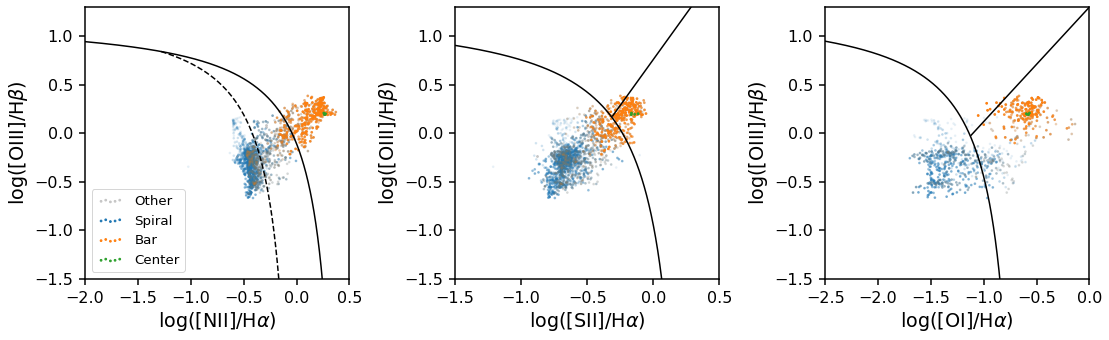

In [7]:
#Set up the plot grid
plt.figure(figsize=(18, 5))
gs = gridspec.GridSpec(1, 3, wspace=0.4)

#Plot the 'log_nii_ha' type BPT diagram in the first plot and include a legend with the feature identification
ax0 = plt.subplot(gs[0])
data.plot_bpt(ax=ax0, bpt_kind='log_nii_ha', s=3)
legend = ax0.legend(loc=3)

# remove transparency from legend
for lh in legend.legendHandles: 
    lh.set_alpha(1)

#Plot another BPT diagram in the second plot    
ax1 = plt.subplot(gs[1])
data.plot_bpt(ax=ax1, bpt_kind='log_sii_ha', s=3)

#Plot another BPT diagram in the third plot    
ax2 = plt.subplot(gs[2])
data.plot_bpt(ax=ax2, bpt_kind='log_oi_ha', s=3);

## Obtaining the mean spectra from spaxels in a feature mask

The `get_mean_spectra` method will calculate the weighted mean spectra inside each mask (weighted by classification counts).  After running this method new attributes will become available for `mean_spiral`, `mean_bar`, and `mean_center` that will return `marvin.tools.quantities.spectrum` objects with the mean spectra.  The `error` for these mean spectra is fully calculated and accounts for spacial covariance as outlined in [Westfall et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019AJ....158..231W/abstract) (the paper describing the MaNGA data analysis pipeline).

By using the `inv=True` keyword, `get_mean_spectra` will also calculate the mean spectra of the inverted masks (e.g. mean of all *not* spiral spaxels, etc..).  This can be used for calculating difference spectrum to look for excess inside various masks over the background. This calculation can take a few minutes to finish for galaxies with larger IFUs.

In [8]:
data.get_mean_spectra(inv=True)

[WARNING]: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here. (DeprecationWarning)
[WARNING]: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information. (DeprecationWarning)


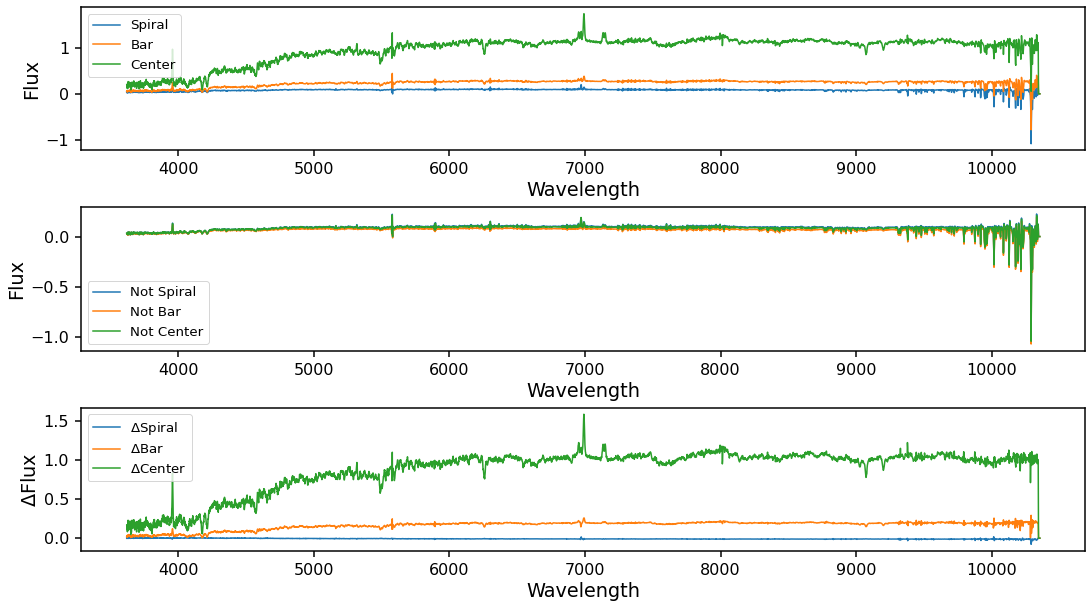

In [9]:
plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(3, 1, hspace=0.4)

# Mean spectra for Spiral, Bar, and Center masks
ax0 = plt.subplot(gs[0])

ax0.plot(data.mean_spiral.wavelength, data.mean_spiral, color='C0', label='Spiral')
ax0.plot(data.mean_bar.wavelength, data.mean_bar, color='C1', label='Bar')
ax0.plot(data.mean_center.wavelength, data.mean_center, color='C2', label='Center')

ax0.set_xlabel('Wavelength')
ax0.set_ylabel('Flux')
ax0.legend()

# Mean spectra for the inverse masks
ax1 = plt.subplot(gs[1])

ax1.plot(data.mean_not_spiral.wavelength, data.mean_not_spiral, color='C0', label='Not Spiral')
ax1.plot(data.mean_not_bar.wavelength, data.mean_not_bar, color='C1', label='Not Bar')
ax1.plot(data.mean_not_center.wavelength, data.mean_not_center, color='C2', label='Not Center')

ax1.set_xlabel('Wavelength')
ax1.set_ylabel('Flux')
ax1.legend()

# Difference spectra for each mask
ax2 = plt.subplot(gs[2])

ax2.plot(data.mean_not_spiral.wavelength, data.mean_spiral - data.mean_not_spiral, color='C0', label='$\\Delta\\mathrm{{Spiral}}$')
ax2.plot(data.mean_not_bar.wavelength, data.mean_bar - data.mean_not_bar, color='C1', label='$\\Delta\\mathrm{{Bar}}$')
ax2.plot(data.mean_not_center.wavelength, data.mean_center - data.mean_not_center, color='C2', label='$\\Delta\\mathrm{{Center}}$')

ax2.set_xlabel('Wavelength')
ax2.set_ylabel('$\\Delta\\mathrm{{Flux}}$')
ax2.legend();

## Polar plots (Radial and/or Azimuthal Averages)

The final plot types supported by the GZ3D class are polar plots.  These can either be by azimuthal angle, `theta` or normalized radius, `R/R_50`, where `R_50` is the effective radius, or the radius containing 50% of the light from the SDSS image - specifically it is `NSA_ELPETRO_TH50_R` in the DAP file ([see data model](https://data.sdss.org/datamodel/files/MANGA_SPECTRO_ANALYSIS/DRPVER/DAPVER/dapall.html)). Specify which you want by changing the `x_unit` keyword from `theta` to `radius`.  Any individual [MaNGA map](https://sdss-marvin.readthedocs.io/en/latest/tools/maps.html) layer can be passed in under the `key` keyword and you will need to provide the correct `ylabel` (units will automatically be added to the `ylabel` based on the map chosen).

The default map is `D_n 4000`, a spectral index measurement which correlates with stellar population ages (larger values indicate older stars). 

[WARNING]: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead (DeprecationWarning)


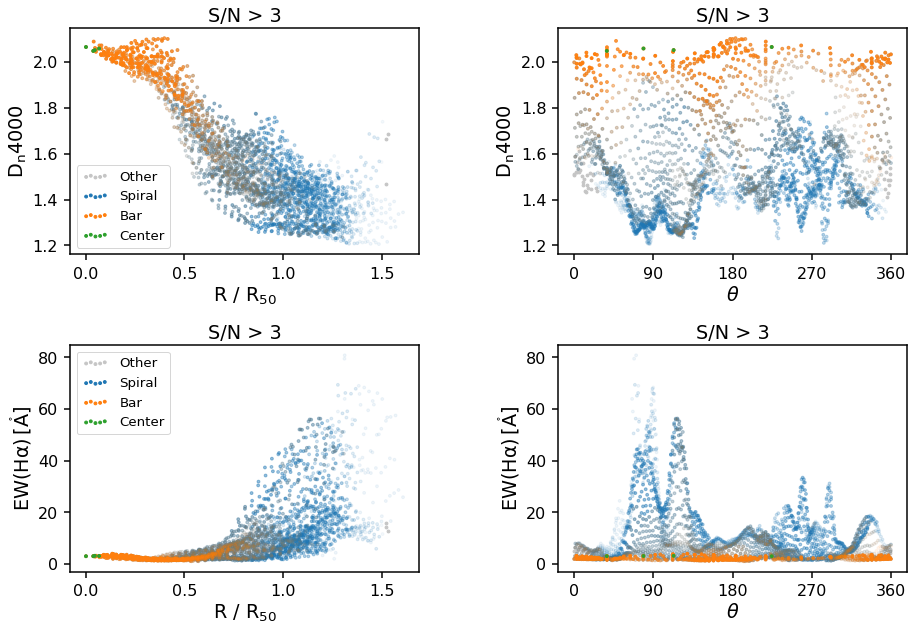

In [10]:
plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 2, hspace=0.4, wspace=0.4)

# D_n 4000 vs radius
ax0 = plt.subplot(gs[0, 0])
data.polar_plot(x_unit='radius', ax=ax0)
legend0 = ax0.legend(loc=3)

# remove transparency from legend
for lh in legend0.legendHandles: 
    lh.set_alpha(1)

# D_n 4000 vs theta
ax1 = plt.subplot(gs[0, 1])
data.polar_plot(x_unit='theta', ax=ax1)

# EW(H-alpha) vs radius
ax2 = plt.subplot(gs[1, 0])
data.polar_plot(x_unit='radius', key='emline_sew_ha_6564', ylabel='EW(H\\alpha)', ax=ax2)
legend2 = ax2.legend(loc=2)

# remove transparency from legend
for lh in legend2.legendHandles: 
    lh.set_alpha(1)

# EW(H-alpha) vs theta
ax3 = plt.subplot(gs[1, 1])
data.polar_plot(x_unit='theta', key='emline_sew_ha_6564', ylabel='EW(H\\alpha)', ax=ax3);

Note that the definition of the zero-point for azimuthal angle, `theta`, is different for each galaxy, as they are set by the orientation of elliptical fits to the photometry (for more information see the explanation of the elliptical polar coordinates of each spaxel from the galaxy center in the [DAP Datamodel](https://data.sdss.org/datamodel/files/MANGA_SPECTRO_ANALYSIS/DRPVER/DAPVER/DAPTYPE/PLATE/IFU/manga-MAPS-DAPTYPE.html#hdu2])).  An easy way to check what direction the zero-point in azimuth points in RA, Dec co-ordinates is by plotting the `theta` map along side the spaxel masks as below:

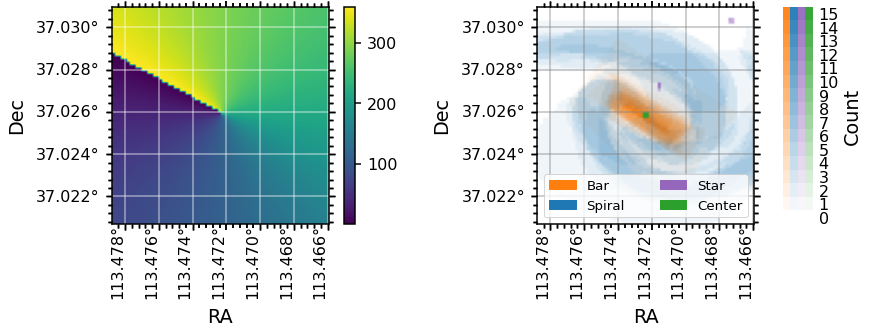

In [11]:
fig = plt.figure(figsize=(13, 4))
gs = gridspec.GridSpec(1, 2, wspace=0.4)

# theta map
ax0 = plt.subplot(gs[0], projection=data.maps.wcs)
im = ax0.imshow(data.maps.spx_ellcoo_elliptical_azimuth.value)
# change the default units and labels on the axes
data._set_up_axes(ax0, color_grid='white')
# incluce a colorbar for the theta map
fig.colorbar(im, ax=ax0)

# plot the spaxel masks
data.plot_masks(color_grid='grey', spaxel_masks=True, subplot_spec=gs[1])
ax1 = fig.axes[1]